# MCMC From Scratch
## Sebastian D. Goodfellow, Ph.D.

In [73]:
# Configure Notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import 3rd party libraries
import math
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dummy Data Example

## Create Dummy Data

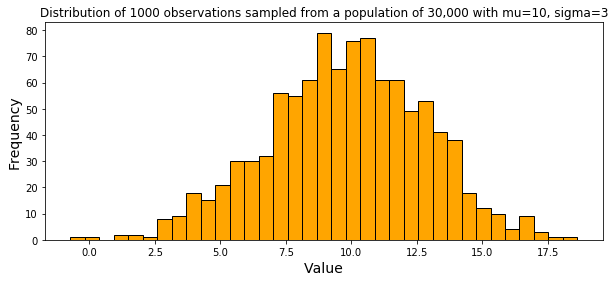

Observed Mean: 9.79271198274179


In [2]:
# Create sample population with nodel distribution (mean: 10, std: 3)
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(observation, bins=35, color='orange', edgecolor='k')
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3')

plt.show()

print('Observed Mean: {}'.format(observation.mean()))

## Implementation

In [3]:
def transition_model(x):
    """
    The tranistion model defines how to move from sigma_current to sigma_new.
    """
    return [x[0], np.random.normal(x[1], 0.5, 1)[0]]

In [4]:
def prior(x):
    """
    x[0] = mu, x[1] = sigma (new or current)
    
    Returns 1 for all valid values of sigma. 
    Log(1) = 0, so it does not affect the summation.
    
    Returns 0 for all invalid values of sigma (<=0). 
    Log(0)=-infinity, and Log(negative number) is undefined.
    
    It makes the new sigma infinitely unlikely.
    """
    if x[1] <= 0:
        return 0
    else:
        return 1

In [5]:
def manual_log_likelihood_normal(x, data):
    """
    Computes the likelihood of the data given a sigma (new or current).
    
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(-np.log(x[1] * np.sqrt(2 * np.pi)) - 
                  ((data - x[0])**2) / (2 * x[1]**2))

In [6]:
def log_likelihood_normal(x, data):
    """
    Same as manual_log_likelihood_normal(x, data), but using scipy implementation #slow.
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(np.log(norm(x[0], x[1]).pdf(data)))

In [7]:
def acceptance(x, x_new):
    """
    Defines whether to accept or reject the new sample.
    """
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number.
        # less likely x_new are less likely to be accepted.
        return (accept < (np.exp(x_new - x)))

In [8]:
def metropolis_hastings(likelihood_computer, prior, transition_model, 
                        param_init, iterations, data, acceptance_rule):
    """
    likelihood_computer(x, data): returns the likelihood that these parameters generated the data.
    transition_model(x): a function that draws a sample from a symmetric distribution and returns it.
    param_init: a starting sample.
    iterations: number of accepted to generated.
    data: the data that we wish to model.
    acceptance_rule(x, x_new): decides whether to accept or reject the new sample.
    """
    x = param_init
    accepted = list()
    rejected = list()
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new))):            
            x = x_new
            accepted.append([x_new[0], x_new[1], i])
        else:
            rejected.append([x_new[0], x_new[1], i])            
                
    return np.array(accepted), np.array(rejected)

## Run The Algorithm 

In [9]:
# Set MCMC iterations
iterations = 5000

# Run
accepted, rejected = metropolis_hastings(
    likelihood_computer=manual_log_likelihood_normal, 
    prior=prior, transition_model=transition_model,
    param_init=[observation.mean(), 0.1],
    iterations=iterations, data=observation, 
    acceptance_rule=acceptance
)

# Print output
print('Interations: {}\nAccepted: {}\nRejected: {}'.format(iterations, accepted.shape[0], rejected.shape[0]))

Interations: 5000
Accepted: 853
Rejected: 4147


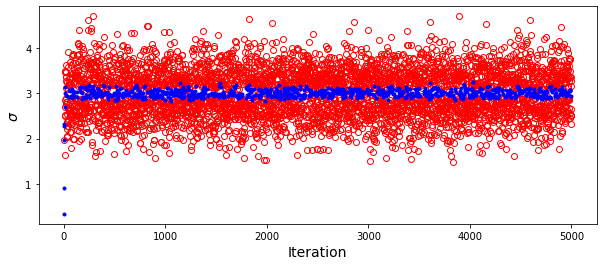

In [10]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
plt.show()

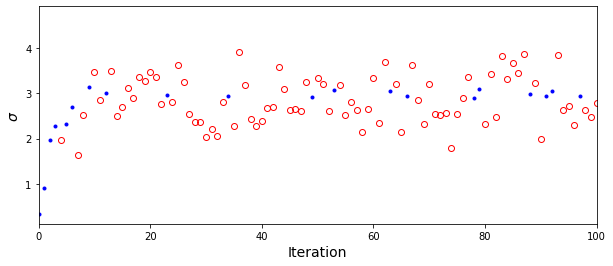

In [11]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_xlim([0, 100])
plt.show()

# Evaluate Results

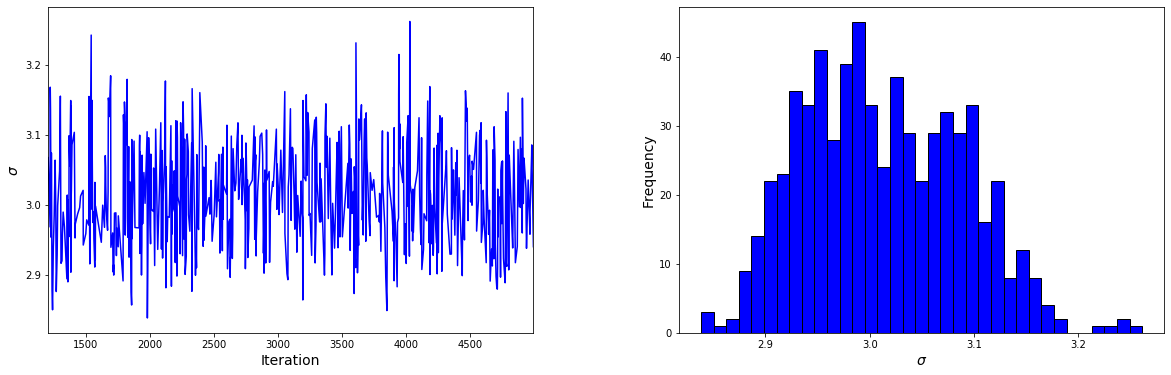

In [12]:
# Plot results
fig = plt.figure(figsize=(20, 6), facecolor='w')
fig.subplots_adjust(wspace=0.3, hspace=0)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(accepted[int(accepted.shape[0] * 0.25):, 2], accepted[int(accepted.shape[0] * 0.25):, 1], '-b')
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('$\sigma$', fontsize=14)
ax1.set_xlim([accepted[int(accepted.shape[0] * 0.25), 2], accepted[accepted.shape[0]-1, 2]])

ax2.hist(accepted[int(accepted.shape[0] * 0.25):, 1], color='b', edgecolor='k', bins=35)
ax2.set_xlabel('$\sigma$', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)

plt.show()

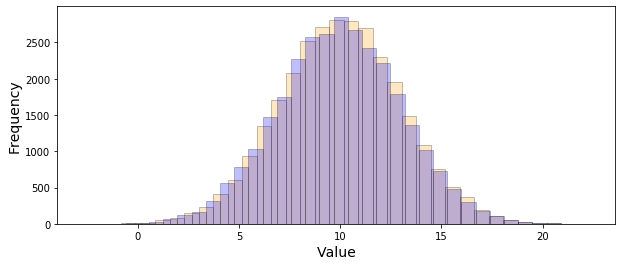

In [13]:
# Create sample population with nodel distribution (mean: 10, std: 3)
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
prediction = np.random.normal(10, np.mean(accepted[int(accepted.shape[0] * 0.25):, 1]), 30000)

# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(population, bins=35, color='orange', edgecolor='k', alpha=0.25)
ax.hist(prediction, bins=35, color='b', edgecolor='k', alpha=0.25)
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

# 2. Real World Example
## Import Sunspot Data

In [28]:
# Import CSV
sp_data = pd.read_csv(
    r'.\..\data\SN_m_tot_v2.0.csv', delimiter=';',
    names=['year', 'month', 'date', 'mean', 'std', 'count', 'marker']
)

# View DataFrame
sp_data.head()

,year,month,date,mean,std,count,marker
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


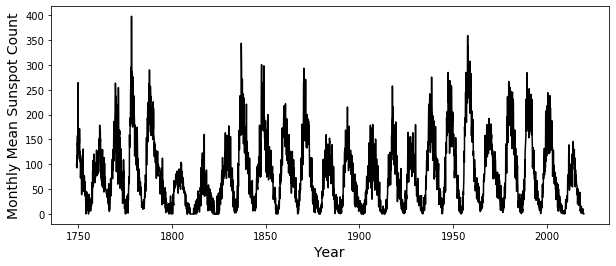

In [30]:
# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sp_data['date'], sp_data['mean'], '-k')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Monthly Mean Sunspot Count', fontsize=14)

plt.show()

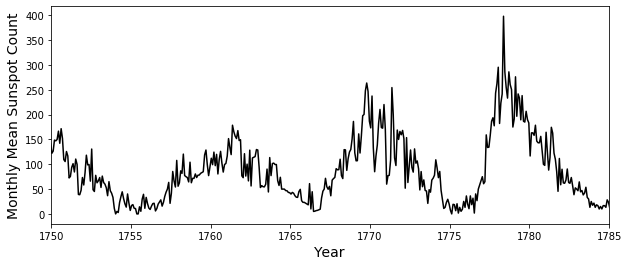

In [32]:
# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sp_data['date'], sp_data['mean'], '-k')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Monthly Mean Sunspot Count', fontsize=14)
ax.set_xlim([1750, 1785])

plt.show()

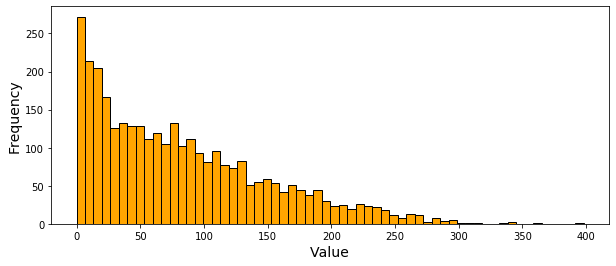

In [58]:
# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(sp_data['mean'], bins=60, color='orange', edgecolor='k')
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

## Model Sunspot Cycles With Gamma Function

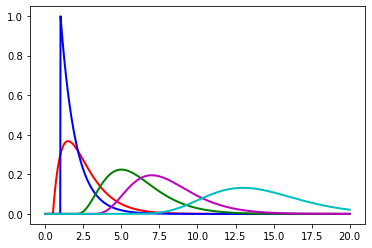

In [55]:
x = np.linspace(0, 20, 1000)
plt.plot(x, gamma.pdf(x=x, a=2, loc=0.5), 'r-', lw=2)
plt.plot(x, gamma.pdf(x=x, a=1, loc=1), 'b-', lw=2)
plt.plot(x, gamma.pdf(x=x, a=4, loc=2), 'g-', lw=2)
plt.plot(x, gamma.pdf(x=x, a=5, loc=3), 'm-', lw=2)
plt.plot(x, gamma.pdf(x=x, a=10, loc=4), 'c-', lw=2)

## Implementation

In [111]:
def transition_model(x):
    """
    The tranistion model defines how to move from sigma_current to sigma_new.
    """
    return np.random.normal(x, [0.05, 5], (2,))

In [112]:
def prior(x):
    if x[0] <= 0 or x[1] <= 0:
        return 0
    else:
        return 1

In [113]:
def manual_log_likelihood_gamma(x, data):
    """
    Computes the likelihood of the data given a sigma (new or current).
    
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum((x[0] - 1) * np.log(data) - (1 / x[1]) * data -
                  x[0] * np.log(x[1]) - np.log(math.gamma(x[0])))

In [114]:
def log_likelihood_gamma(x, data):
    """
    Same as manual_log_likelihood_normal(x, data), but using scipy implementation #slow.
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(np.log(gamma(a=x[0], scale=x[1], loc=0).pdf(data)))  

In [115]:
def acceptance(x, x_new):
    """
    Defines whether to accept or reject the new sample.
    """
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number.
        # less likely x_new are less likely to be accepted.
        return (accept < (np.exp(x_new - x)))

In [122]:
def metropolis_hastings(likelihood_computer, prior, transition_model, 
                        param_init, iterations, data, acceptance_rule):
    """
    likelihood_computer(x, data): returns the likelihood that these parameters generated the data.
    transition_model(x): a function that draws a sample from a symmetric distribution and returns it.
    param_init: a starting sample.
    iterations: number of accepted to generated.
    data: the data that we wish to model.
    acceptance_rule(x, x_new): decides whether to accept or reject the new sample.
    """
    x = param_init
    accepted = list()
    rejected = list()
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        print(x, x_new, x_lik, x_new_lik)
        if acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new))):            
            x = x_new
            accepted.append([x_new[0], x_new[1], i])
        else:
            rejected.append([x_new[0], x_new[1], i])            
                
    return np.array(accepted), np.array(rejected)

## Run The Algorithm 

In [123]:
# Set MCMC iterations
iterations = 10

# Run
accepted, rejected = metropolis_hastings(
    likelihood_computer=manual_log_likelihood_gamma, 
    prior=prior, transition_model=transition_model,
    param_init=[4, 10],
    iterations=iterations, data=sp_data['mean'].values, 
    acceptance_rule=acceptance
)

# Print output
print('Interations: {}\nAccepted: {}\nRejected: {}'.format(iterations, accepted.shape[0], rejected.shape[0]))

[4, 10] [3.97392726 7.52545016] -inf -inf
[4, 10] [ 3.93061849 12.5081616 ] -inf -inf
[4, 10] [4.00299608 9.76135044] -inf -inf
[4, 10] [ 4.02520007 17.26193274] -inf -inf
[4, 10] [ 3.97500549 15.86908753] -inf -inf
[4, 10] [ 4.06296699 16.60084189] -inf -inf
[4, 10] [4.06155516 4.85133442] -inf -inf
[4, 10] [ 4.04333428 10.86001668] -inf -inf
[4, 10] [3.98381177 2.57582935] -inf -inf
[4, 10] [4.0013609  4.21920033] -inf -inf
Interations: 10
Accepted: 0
Rejected: 10


In [103]:
sp_data['mean'].values

array([ 96.7, 104.3, 116.7, ...,   0.7,   1.1,   0.4])

In [119]:
accepted

array([], dtype=float64)

(array([8.0000e+00, 1.5700e+02, 1.3580e+03, 5.8580e+03, 1.3507e+04,
        1.5870e+04, 9.5950e+03, 3.0900e+03, 5.1600e+02, 4.1000e+01]),
 array([-11.78955067,  -7.64140112,  -3.49325157,   0.65489798,
          4.80304753,   8.95119709,  13.09934664,  17.24749619,
         21.39564574,  25.54379529,  29.69194485]),
 <a list of 10 Patch objects>)

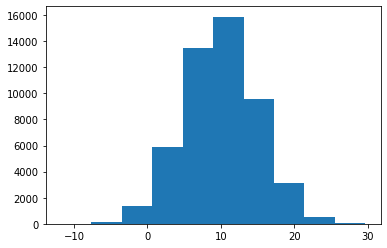

In [108]:
plt.hist(rejected[:, 1])